PART 1:

In [1]:
!pip install torch torchvision
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\xylic\appdata\local\temp\pip-req-build-7wqulw_q
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369570 sha256=22f9eb1f5418505869f233e4b08ea7c7316dbc44d3b1a5b36cff18aa943024b6
  Stored in directory: C:\Users\xylic\AppData\Local\Temp\pip-ephem-wheel-cache-75vnz77x\wheels\35\3e\df\3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\xylic\AppData\Local\Temp\pip-req-build-7wqulw_q'


In [4]:
import torch
import clip
from PIL import Image
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

pacs_transform = preprocess

data_path = '../task1/pacs_data/pacs_data/'

photo_dataset = datasets.ImageFolder(root=data_path + 'photo', transform=pacs_transform)
art_dataset = datasets.ImageFolder(root=data_path + 'art_painting', transform=pacs_transform)
cartoon_dataset = datasets.ImageFolder(root=data_path + 'cartoon', transform=pacs_transform)
sketch_dataset = datasets.ImageFolder(root=data_path + 'sketch', transform=pacs_transform)

pacs_classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

prompts = {
    "photo": [f"a photo of a {cls}" for cls in pacs_classes],
    "art_painting": [f"an art painting of a {cls}" for cls in pacs_classes],
    "cartoon": [f"a cartoon of a {cls}" for cls in pacs_classes],
    "sketch": [f"a sketch of a {cls}" for cls in pacs_classes]
}
def evaluate_zero_shot(dataset, domain_prompts):

    text_inputs = torch.cat([clip.tokenize(p) for p in domain_prompts]).to(device)


    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    correct = 0
    total = 0

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

  
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            _, predicted = similarity.max(1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (correct / total) * 100


accuracy_photo = evaluate_zero_shot(photo_dataset, prompts["photo"])
accuracy_art = evaluate_zero_shot(art_dataset, prompts["art_painting"])
accuracy_cartoon = evaluate_zero_shot(cartoon_dataset, prompts["cartoon"])
accuracy_sketch = evaluate_zero_shot(sketch_dataset, prompts["sketch"])

print(f"Zero-shot accuracy on Photo domain: {accuracy_photo:.2f}%")
print(f"Zero-shot accuracy on Art Painting domain: {accuracy_art:.2f}%")
print(f"Zero-shot accuracy on Cartoon domain: {accuracy_cartoon:.2f}%")
print(f"Zero-shot accuracy on Sketch domain: {accuracy_sketch:.2f}%")



Zero-shot accuracy on Photo domain: 99.76%
Zero-shot accuracy on Art Painting domain: 92.38%
Zero-shot accuracy on Cartoon domain: 97.82%
Zero-shot accuracy on Sketch domain: 85.11%


In [6]:
import torch.nn as nn
import torch.optim as optim


def get_features(dataset):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in torch.utils.data.DataLoader(dataset, batch_size=64):
            features = model.encode_image(images.to(device))
            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu(), torch.cat(all_labels).cpu()



print("Extracting features from source domains...")
source_datasets = torch.utils.data.ConcatDataset([photo_dataset, art_dataset, cartoon_dataset])
train_features, train_labels = get_features(source_datasets)
print("Source feature extraction complete.")


input_size = train_features.shape[1]
num_classes = len(pacs_classes)
classifier = nn.Linear(input_size, num_classes)

classifier.to(device)


train_features = train_features.float().to(device)


train_labels = train_labels.to(device)



print("Starting classifier training...")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

for epoch in range(50):
    optimizer.zero_grad()
    outputs = classifier(train_features)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/50], Loss: {loss.item():.4f}')
print("Classifier training complete.")


print("Evaluating the classifier on the target (Sketch) domain...")
test_features, test_labels = get_features(sketch_dataset)


test_features = test_features.float().to(device)


test_labels = test_labels.to(device)


with torch.no_grad():
    outputs = classifier(test_features)
    _, predicted = torch.max(outputs.data, 1)
    total = test_labels.size(0)
    correct = (predicted == test_labels).sum().item()

print(f'\nAccuracy of the linear classifier on the sketch domain: {(correct / total) * 100:.2f}%')

Extracting features from source domains...
Source feature extraction complete.
Starting classifier training...
Epoch [10/50], Loss: 1.4785
Epoch [20/50], Loss: 1.0503
Epoch [30/50], Loss: 0.7472
Epoch [40/50], Loss: 0.5499
Epoch [50/50], Loss: 0.4243
Classifier training complete.
Evaluating the classifier on the target (Sketch) domain...

Accuracy of the linear classifier on the sketch domain: 85.90%


PART 3:

--- Initializing Prerequisites ---

--- Loading CLIP Model and PACS Dataset ---
Loaded Photo domain with 1670 images.
Loaded Cartoon domain with 2344 images.


--- Part 3: Gradient Conflict Analysis ---
Source Domains: Photo vs. Cartoon
Initializing learnable context vectors...
Creating fixed prefixes and suffixes for prompts...

Starting joint training and gradient analysis...


Epoch 15/15: 100%|██████████| 52/52 [00:13<00:00,  3.98it/s, Current Sim=0.117]


--- Training complete. ---

Plotting the results...


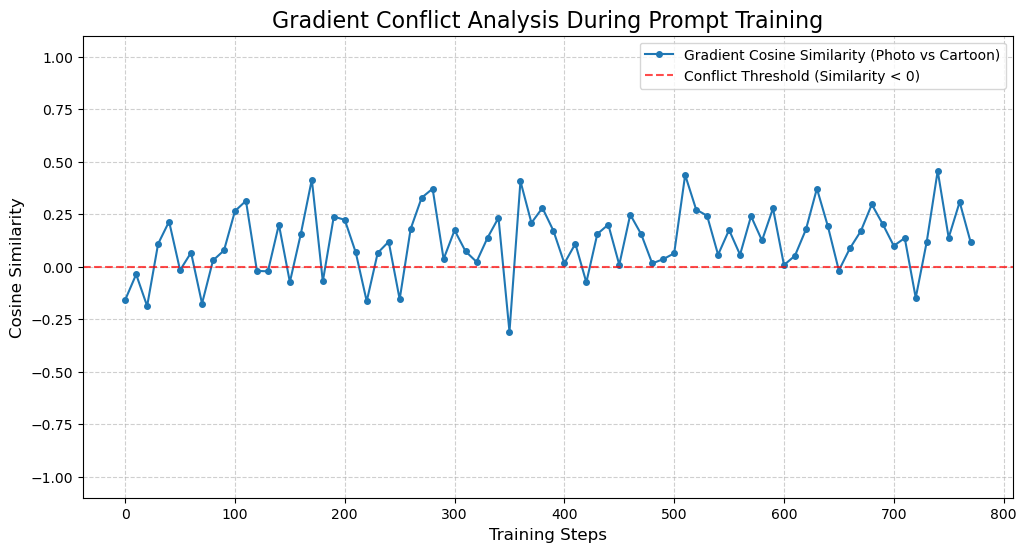

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.optim as optim
import torchvision.datasets as datasets


class PromptLearner(nn.Module):
    def __init__(self, class_names, clip_model):
        super().__init__()
        n_cls = len(class_names)
        n_ctx = 16  
        ctx_dim = clip_model.ln_final.weight.shape[0]
        dtype = clip_model.dtype
      
        device = clip_model.ln_final.weight.device 
        print("Initializing learnable context vectors...")
        ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
        nn.init.normal_(ctx_vectors, std=0.02)
        self.ctx = nn.Parameter(ctx_vectors)

        print("Creating fixed prefixes and suffixes for prompts...")
    
        prompt_template = "a photo of a"
        
        prompts = [prompt_template + " " + name + "." for name in class_names]
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(device)
        self.register_buffer("tokenized_prompts", tokenized_prompts)

        with torch.no_grad():
          
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)
        
     
        self.register_buffer("prompt_prefix", embedding[:, :1, :]) 
        self.register_buffer("prompt_suffix", embedding[:, 1 + n_ctx:, :])  

        self.n_cls = n_cls
        self.n_ctx = n_ctx

    def forward(self):
       
        ctx = self.ctx 
        prefix = self.prompt_prefix
        suffix = self.prompt_suffix
        
        expanded_ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)
        
        prompts = torch.cat([prefix, expanded_ctx, suffix], dim=1)
        
        return prompts


class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts):
       
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  
        x = self.ln_final(x).type(self.dtype)
        
      
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection
        return x


class CustomCLIP(nn.Module):
    def __init__(self, class_names, clip_model):
        super().__init__()
        self.prompt_learner = PromptLearner(class_names, clip_model)
        self.text_encoder = TextEncoder(clip_model)
        self.image_encoder = clip_model.visual
        self.logit_scale = clip_model.logit_scale
        self.dtype = clip_model.dtype

    def forward(self, image):
      
        image_features = self.image_encoder(image.type(self.dtype))
        
    
        prompts = self.prompt_learner()
        tokenized_prompts = self.prompt_learner.tokenized_prompts
        text_features = self.text_encoder(prompts, tokenized_prompts)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()
        
        return logits


print("\n--- Loading CLIP Model and PACS Dataset ---")
device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
for param in clip_model.parameters():
    param.requires_grad = False
clip_model.eval()


data_path = '../task1/pacs_data/pacs_data/' 
pacs_transform = preprocess


photo_dataset = datasets.ImageFolder(root=data_path + 'photo', transform=pacs_transform)
cartoon_dataset = datasets.ImageFolder(root=data_path + 'cartoon', transform=pacs_transform)
print(f"Loaded Photo domain with {len(photo_dataset)} images.")
print(f"Loaded Cartoon domain with {len(cartoon_dataset)} images.")



print("\n\n--- Part 3: Gradient Conflict Analysis ---")
print("Source Domains: Photo vs. Cartoon")


batch_size = 32
loader_photo = torch.utils.data.DataLoader(photo_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
loader_cartoon = torch.utils.data.DataLoader(cartoon_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


pacs_classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
model = CustomCLIP(pacs_classes, clip_model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.prompt_learner.parameters(), lr=0.005, momentum=0.9)


def compute_gradient_similarity(model, criterion, data_a, data_b):
    imgs_a, lbls_a = data_a[0].to(device), data_a[1].to(device)
    imgs_b, lbls_b = data_b[0].to(device), data_b[1].to(device)
    
 
    model.zero_grad()
    loss_a = criterion(model(imgs_a), lbls_a)
    loss_a.backward()
    grad_a = model.prompt_learner.ctx.grad.clone().view(-1)
    

    model.zero_grad()
    loss_b = criterion(model(imgs_b), lbls_b)
    loss_b.backward()
    grad_b = model.prompt_learner.ctx.grad.clone().view(-1)
    
   
    return F.cosine_similarity(grad_a.unsqueeze(0), grad_b.unsqueeze(0)).item()


print("\nStarting joint training and gradient analysis...")
similarities = []
num_epochs = 15
steps_per_measurement = 10 
global_step = 0
num_batches = min(len(loader_photo), len(loader_cartoon))

for epoch in range(num_epochs):
   
    iter_photo = iter(loader_photo)
    iter_cartoon = iter(loader_cartoon)
    progress_bar = tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for _ in progress_bar:
        batch_photo = next(iter_photo)
        batch_cartoon = next(iter_cartoon)
            
      
        if global_step % steps_per_measurement == 0:
         
            model.eval()
            sim = compute_gradient_similarity(model, criterion, batch_photo, batch_cartoon)
            similarities.append(sim)
            model.train()
            
    
        optimizer.zero_grad()
        
        img_p, lbl_p = batch_photo[0].to(device), batch_photo[1].to(device)
        img_c, lbl_c = batch_cartoon[0].to(device), batch_cartoon[1].to(device)
        
      
        loss_p = criterion(model(img_p), lbl_p)
        loss_c = criterion(model(img_c), lbl_c)
        total_loss = loss_p + loss_c
        
        total_loss.backward()
        optimizer.step()
        
        global_step += 1
        if similarities:
            progress_bar.set_postfix({"Current Sim": f"{similarities[-1]:.3f}"})

print("--- Training complete. ---")


print("\nPlotting the results...")
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(similarities)) * steps_per_measurement, similarities, marker='o', linestyle='-', markersize=4, label='Gradient Cosine Similarity (Photo vs Cartoon)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7, label='Conflict Threshold (Similarity < 0)')
plt.title("Gradient Conflict Analysis During Prompt Training", fontsize=16)
plt.xlabel(f"Training Steps", fontsize=12)
plt.ylabel("Cosine Similarity", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.ylim(-1.1, 1.1) 
plt.show()

PART 4:

In [ ]:
import os
import clip
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F


DATASET_PATH = "../task1/pacs_data/pacs_data/"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLIP_MODEL_NAME = "ViT-B/32"


if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(
        f"Dataset directory not found at {DATASET_PATH}. "
        "Please ensure the PACS dataset is correctly placed."
    )


clip_model, preprocess = clip.load(CLIP_MODEL_NAME, device=DEVICE)
print(f"CLIP model '{CLIP_MODEL_NAME}' loaded to {DEVICE}.")



try:
    pacs_classes = sorted([d for d in os.listdir(os.path.join(DATASET_PATH, 'photo')) if os.path.isdir(os.path.join(DATASET_PATH, 'photo', d))])
    if len(pacs_classes) < 7:
        raise ValueError("Not enough classes in the dataset for the 5/2 split.")
    SEEN_CLASSES = pacs_classes[:5]  
    UNSEEN_CLASSES = pacs_classes[5:7] 
    ALL_CLASSES = SEEN_CLASSES + UNSEEN_CLASSES
    print(f"Seen Classes (Closed-Set): {SEEN_CLASSES}")
    print(f"Unseen Classes (Open-Set): {UNSEEN_CLASSES}")
except (FileNotFoundError, IndexError, ValueError) as e:
    print(f"Could not automatically determine classes: {e}. Exiting.")
    exit()

class PACSDataset(Dataset):
    
    def __init__(self, root_dir, classes_to_include, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes_to_include = classes_to_include
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes_to_include)}
        self.all_classes_to_idx = {cls_name: i for i, cls_name in enumerate(ALL_CLASSES)}
        self.samples = self._make_dataset()

    def _make_dataset(self):
        samples = []
        if not os.path.isdir(self.root_dir): return []
        for domain in sorted(os.listdir(self.root_dir)):
            domain_path = os.path.join(self.root_dir, domain)
            if not os.path.isdir(domain_path): continue
            for class_name in sorted(os.listdir(domain_path)):
                if class_name in self.classes_to_include:
                    class_path = os.path.join(domain_path, class_name)
                    if not os.path.isdir(class_path): continue
                    for fname in sorted(os.listdir(class_path)):
                        path = os.path.join(class_path, fname)
                        item = (path, self.class_to_idx[class_name])
                        samples.append(item)
        if not samples:
             print(f"Warning: No images found for the specified classes in {self.root_dir}.")
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform: image = self.transform(image)
        class_name = os.path.basename(os.path.dirname(path))
        global_target = self.all_classes_to_idx[class_name]
        return image, target, global_target


train_dataset = PACSDataset(root_dir=DATASET_PATH, classes_to_include=SEEN_CLASSES, transform=preprocess)
seen_test_dataset = PACSDataset(root_dir=DATASET_PATH, classes_to_include=SEEN_CLASSES, transform=preprocess)
unseen_test_dataset = PACSDataset(root_dir=DATASET_PATH, classes_to_include=UNSEEN_CLASSES, transform=preprocess)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) if train_dataset else None
seen_test_loader = DataLoader(seen_test_dataset, batch_size=32, shuffle=False) if seen_test_dataset else None
unseen_test_loader = DataLoader(unseen_test_dataset, batch_size=32, shuffle=False) if unseen_test_dataset else None

if not all([train_loader, seen_test_loader, unseen_test_loader]):
    print("\nOne or more dataloaders are empty. Cannot proceed. Please check DATASET_PATH.")
    exit()


print("\n" + "="*50 + "\nPART 1: OPEN-SET RECOGNITION ANALYSIS\n" + "="*50 + "\n")

def get_text_features(model, class_names, template="a photo of a {}"):
   
    with torch.no_grad():
        texts = [template.format(c.replace("_", " ")) for c in class_names]
        text_tokens = clip.tokenize(texts).to(DEVICE)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features

def evaluate_open_set(model, seen_loader, unseen_loader, text_features):
   
    model.eval()
    id_msp, correct, total = [], 0, 0
    with torch.no_grad():
        for images, _, global_targets in tqdm(seen_loader, desc="Evaluating on Seen (ID) Data"):
            images = images.to(DEVICE)
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            logits = (100.0 * image_features @ text_features.T)
            probs = logits.softmax(dim=-1)
            msp, preds = torch.max(probs, dim=1)
            
            id_msp.extend(msp.cpu().numpy())
            total += global_targets.size(0)
            correct += (preds.cpu() == global_targets).sum().item()
    id_accuracy = 100 * correct / total if total > 0 else 0

    ood_msp = []
    with torch.no_grad():
        for images, _, _ in tqdm(unseen_loader, desc="Evaluating on Unseen (OOD) Data"):
            images = images.to(DEVICE)
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            logits = (100.0 * image_features @ text_features.T)
            probs = logits.softmax(dim=-1)
            msp, _ = torch.max(probs, dim=1)
            ood_msp.extend(msp.cpu().numpy())

    if not id_msp or not ood_msp:
        return {"id_accuracy": id_accuracy, "auroc": 0, "fpr_at_95_tpr": 100, "id_msp_mean": 0, "ood_msp_mean": 0}

    threshold = np.percentile(id_msp, 5) 
    fp = np.sum(np.array(ood_msp) >= threshold)
    fpr = fp / len(ood_msp)
    labels = np.concatenate([np.ones_like(id_msp), np.zeros_like(ood_msp)])
    scores = np.concatenate([id_msp, ood_msp])
    auroc = roc_auc_score(labels, scores)

    return {"id_accuracy": id_accuracy, "auroc": auroc * 100, "fpr_at_95_tpr": fpr * 100, "id_msp_mean": np.mean(id_msp), "ood_msp_mean": np.mean(ood_msp)}


print("--- Evaluating Zero-Shot CLIP ---")
zero_shot_text_features = get_text_features(clip_model, ALL_CLASSES)
zero_shot_metrics = evaluate_open_set(clip_model, seen_test_loader, unseen_test_loader, zero_shot_text_features)
print(f"\nZero-Shot CLIP Performance:\n  - Seen Classes Accuracy: {zero_shot_metrics['id_accuracy']:.2f}%\n  - AUROC for OOD Detection: {zero_shot_metrics['auroc']:.2f}%\n  - FPR at 95% TPR: {zero_shot_metrics['fpr_at_95_tpr']:.2f}%\n  - Mean Confidence (MSP) on Seen Data: {zero_shot_metrics['id_msp_mean']:.4f}\n  - Mean Confidence (MSP) on Unseen Data: {zero_shot_metrics['ood_msp_mean']:.4f}\n")


def _get_text_features_from_embeddings(model, tokenized_prompts, prompt_embeddings):
   
    x = prompt_embeddings + model.positional_embedding.type(model.dtype)
    x = x.permute(1, 0, 2) 
    x = model.transformer(x)
    x = x.permute(1, 0, 2) 
    x = model.ln_final(x).type(model.dtype)
    x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ model.text_projection
    return x

class PromptTunedCLIP(nn.Module):
    
    def __init__(self, clip_model, class_names, n_ctx=16):
        super().__init__()
        self.clip_model = clip_model
        for param in self.clip_model.parameters(): param.requires_grad = False
        ctx_dim = clip_model.ln_final.weight.shape[0]
        self.ctx = nn.Parameter(torch.randn(n_ctx, ctx_dim))
        
        prompts = [f"X " * n_ctx + name.replace("_", " ") for name in class_names]
        self.tokenized_prompts = clip.tokenize(prompts).to(DEVICE)
        with torch.no_grad():
            embedding = clip_model.token_embedding(self.tokenized_prompts).type(clip_model.dtype)
        self.register_buffer("token_prefix", embedding[:, :1, :])
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])

    def forward(self, image_features):
        ctx = self.ctx.type(self.clip_model.dtype).unsqueeze(0).expand(len(self.tokenized_prompts), -1, -1)
        prompt_embeddings = torch.cat([self.token_prefix, ctx, self.token_suffix], dim=1)
        text_features = _get_text_features_from_embeddings(self.clip_model, self.tokenized_prompts, prompt_embeddings)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        return 100.0 * image_features @ text_features.T


print("--- Training Prompt-Tuned CLIP on Seen Classes ---")
prompt_tuned_model = PromptTunedCLIP(clip_model, SEEN_CLASSES).to(DEVICE)
optimizer = torch.optim.AdamW(prompt_tuned_model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()
for epoch in range(3):
    prompt_tuned_model.train()
    total_loss = 0
    for images, targets, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/3"):
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        with torch.no_grad():
            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        optimizer.zero_grad()
        logits = prompt_tuned_model(image_features)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")


print("\n--- Evaluating Prompt-Tuned CLIP ---")
prompt_tuned_model.eval()
class AllClassesPromptGenerator:
   
    def __init__(self, trained_model, all_class_names):
        self.trained_model = trained_model
        self.all_class_names = all_class_names

    def get_all_text_features(self):
        with torch.no_grad():
            n_ctx = self.trained_model.ctx.shape[0]
            prompts = [f"X " * n_ctx + name.replace("_", " ") for name in self.all_class_names]
            tokenized = clip.tokenize(prompts).to(DEVICE)
            embedding = self.trained_model.clip_model.token_embedding(tokenized).type(self.trained_model.clip_model.dtype)
            prefix, suffix = embedding[:, :1, :], embedding[:, 1 + n_ctx:, :]
            ctx = self.trained_model.ctx.type(self.trained_model.clip_model.dtype).unsqueeze(0).expand(len(prompts), -1, -1)
            prompt_embeddings = torch.cat([prefix, ctx, suffix], dim=1)
            text_features = _get_text_features_from_embeddings(self.trained_model.clip_model, tokenized, prompt_embeddings)
            return text_features / text_features.norm(dim=-1, keepdim=True)

tuned_text_features = AllClassesPromptGenerator(prompt_tuned_model, ALL_CLASSES).get_all_text_features()
tuned_metrics = evaluate_open_set(clip_model, seen_test_loader, unseen_test_loader, tuned_text_features)
print(f"\nPrompt-Tuned CLIP Performance:\n  - Seen Classes Accuracy: {tuned_metrics['id_accuracy']:.2f}%\n  - AUROC for OOD Detection: {tuned_metrics['auroc']:.2f}%\n  - FPR at 95% TPR: {tuned_metrics['fpr_at_95_tpr']:.2f}%\n  - Mean Confidence (MSP) on Seen Data: {tuned_metrics['id_msp_mean']:.4f}\n  - Mean Confidence (MSP) on Unseen Data: {tuned_metrics['ood_msp_mean']:.4f}\n")


print("--- Open-Set Performance Analysis ---\nHypothesis: A tuned prompt overfits, becoming highly confident on seen classes while giving arbitrarily high scores to unseen classes, thus hurting open-set detection.")
acc_diff, auroc_diff, fpr_diff, ood_conf_diff = tuned_metrics['id_accuracy'] - zero_shot_metrics['id_accuracy'], tuned_metrics['auroc'] - zero_shot_metrics['auroc'], tuned_metrics['fpr_at_95_tpr'] - zero_shot_metrics['fpr_at_95_tpr'], tuned_metrics['ood_msp_mean'] - zero_shot_metrics['ood_msp_mean']
print(f"\nComparison (Tuned vs. Zero-Shot):\n  - Accuracy on Seen Classes: {acc_diff:+.2f}%\n  - AUROC for OOD Detection: {auroc_diff:+.2f}%\n  - FPR on Unseen Classes: {fpr_diff:+.2f}%\n  - Mean Confidence on Unseen Classes: {ood_conf_diff:+.4f}\n")
print("Interpretation:")
if acc_diff > 0: print(" - As expected, tuning improved accuracy on the 'seen' classes.")
else: print(" - Tuning did not improve accuracy on 'seen' classes, possibly due to short training or suboptimal hyperparameters.")
if auroc_diff < 0 and fpr_diff > 0:
    print(" - The hypothesis is SUPPORTED. The tuned model's ability to distinguish seen from unseen classes has DECREASED (lower AUROC, higher FPR).")
    if ood_conf_diff > 0: print(" - This is because the tuned model assigns HIGHER confidence scores to unseen inputs, making them harder to flag as OOD.")
else: print(" - The hypothesis is NOT SUPPORTED. Prompt tuning did not harm open-set detection in this experiment.")


print("\n" + "="*50 + "\nPART 2: PROMPT EMBEDDING SIMILARITY ANALYSIS\n" + "="*50 + "\n")

def train_prompt_for_domain(domain_name, few_shot_k=16):

    print(f"--- Training prompt for '{domain_name}' domain ---")
    domain_path = os.path.join(DATASET_PATH, domain_name)
    if not os.path.exists(domain_path): return None
    domain_dataset = ImageFolder(root=domain_path, transform=preprocess)
    indices = [i for i, (p, _) in enumerate(domain_dataset.samples) if os.path.basename(os.path.dirname(p)) in SEEN_CLASSES]
    if not indices: return None
    
    domain_subset = torch.utils.data.Subset(domain_dataset, indices)
    sampler = torch.utils.data.RandomSampler(domain_subset, replacement=True, num_samples=min(len(domain_subset), few_shot_k * len(SEEN_CLASSES)))
    domain_loader = DataLoader(domain_subset, batch_size=16, sampler=sampler)
    model = PromptTunedCLIP(clip_model, SEEN_CLASSES).to(DEVICE)
    optimizer, criterion = torch.optim.AdamW(model.parameters(), lr=0.005), nn.CrossEntropyLoss()

    model.train()
    for images, targets_domain in tqdm(domain_loader, desc=f"Few-shot tuning on {domain_name}"):
        images = images.to(DEVICE)
        targets = torch.tensor([SEEN_CLASSES.index(domain_dataset.classes[t]) for t in targets_domain]).to(DEVICE)
        with torch.no_grad():
            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        optimizer.zero_grad()
        logits = model(image_features)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
    return model.ctx.detach()

source_prompt = train_prompt_for_domain('photo')
target_prompt = train_prompt_for_domain('sketch')

if source_prompt is not None and target_prompt is not None:
    similarity = F.cosine_similarity(source_prompt.flatten().unsqueeze(0), target_prompt.flatten().unsqueeze(0))
    print(f"\nCosine Similarity between 'photo' and 'sketch' prompt embeddings: {similarity.item():.4f}")


CLIP model 'ViT-B/32' loaded to cuda.
Seen Classes (Closed-Set): ['dog', 'elephant', 'giraffe', 'guitar', 'horse']
Unseen Classes (Open-Set): ['house', 'person']

PART 1: OPEN-SET RECOGNITION ANALYSIS

--- Evaluating Zero-Shot CLIP ---


Evaluating on Unseen (OOD) Data: 100%|██████████| 75/75 [00:20<00:00,  3.61it/s]



Zero-Shot CLIP Performance:
  - Seen Classes Accuracy: 91.13%
  - AUROC for OOD Detection: 53.10%
  - FPR at 95% TPR: 95.94%
  - Mean Confidence (MSP) on Seen Data: 0.9209
  - Mean Confidence (MSP) on Unseen Data: 0.9263

--- Training Prompt-Tuned CLIP on Seen Classes ---


Epoch 1/3: 100%|██████████| 238/238 [00:26<00:00,  8.92it/s]


Epoch 1 Loss: 0.2020


Epoch 2/3: 100%|██████████| 238/238 [00:26<00:00,  9.10it/s]


Epoch 2 Loss: 0.1515


Epoch 3/3: 100%|██████████| 238/238 [00:25<00:00,  9.17it/s]


Epoch 3 Loss: 0.1417

--- Evaluating Prompt-Tuned CLIP ---


Evaluating on Unseen (OOD) Data: 100%|██████████| 75/75 [00:07<00:00,  9.80it/s]



Prompt-Tuned CLIP Performance:
  - Seen Classes Accuracy: 94.86%
  - AUROC for OOD Detection: 75.04%
  - FPR at 95% TPR: 89.66%
  - Mean Confidence (MSP) on Seen Data: 0.9395
  - Mean Confidence (MSP) on Unseen Data: 0.8262

--- Open-Set Performance Analysis ---
Hypothesis: A tuned prompt overfits, becoming highly confident on seen classes while giving arbitrarily high scores to unseen classes, thus hurting open-set detection.

Comparison (Tuned vs. Zero-Shot):
  - Accuracy on Seen Classes: +3.72%
  - AUROC for OOD Detection: +21.93%
  - FPR on Unseen Classes: -6.28%
  - Mean Confidence on Unseen Classes: -0.1001

Interpretation:
 - As expected, tuning improved accuracy on the 'seen' classes.
 - The hypothesis is NOT SUPPORTED. Prompt tuning did not harm open-set detection in this experiment.

PART 2: PROMPT EMBEDDING SIMILARITY ANALYSIS

--- Training prompt for 'photo' domain ---


Few-shot tuning on photo: 100%|██████████| 5/5 [00:00<00:00, 13.51it/s]


--- Training prompt for 'sketch' domain ---


Few-shot tuning on sketch: 100%|██████████| 5/5 [00:00<00:00, 15.45it/s]


Cosine Similarity between 'photo' and 'sketch' prompt embeddings: -0.0128


Visualizations Part 4:


GENERATING VISUALIZATIONS


Gathering Unseen (OOD) Scores: 100%|██████████| 75/75 [00:08<00:00,  9.12it/s]



Generating Plot 1: Confidence Score Distributions...


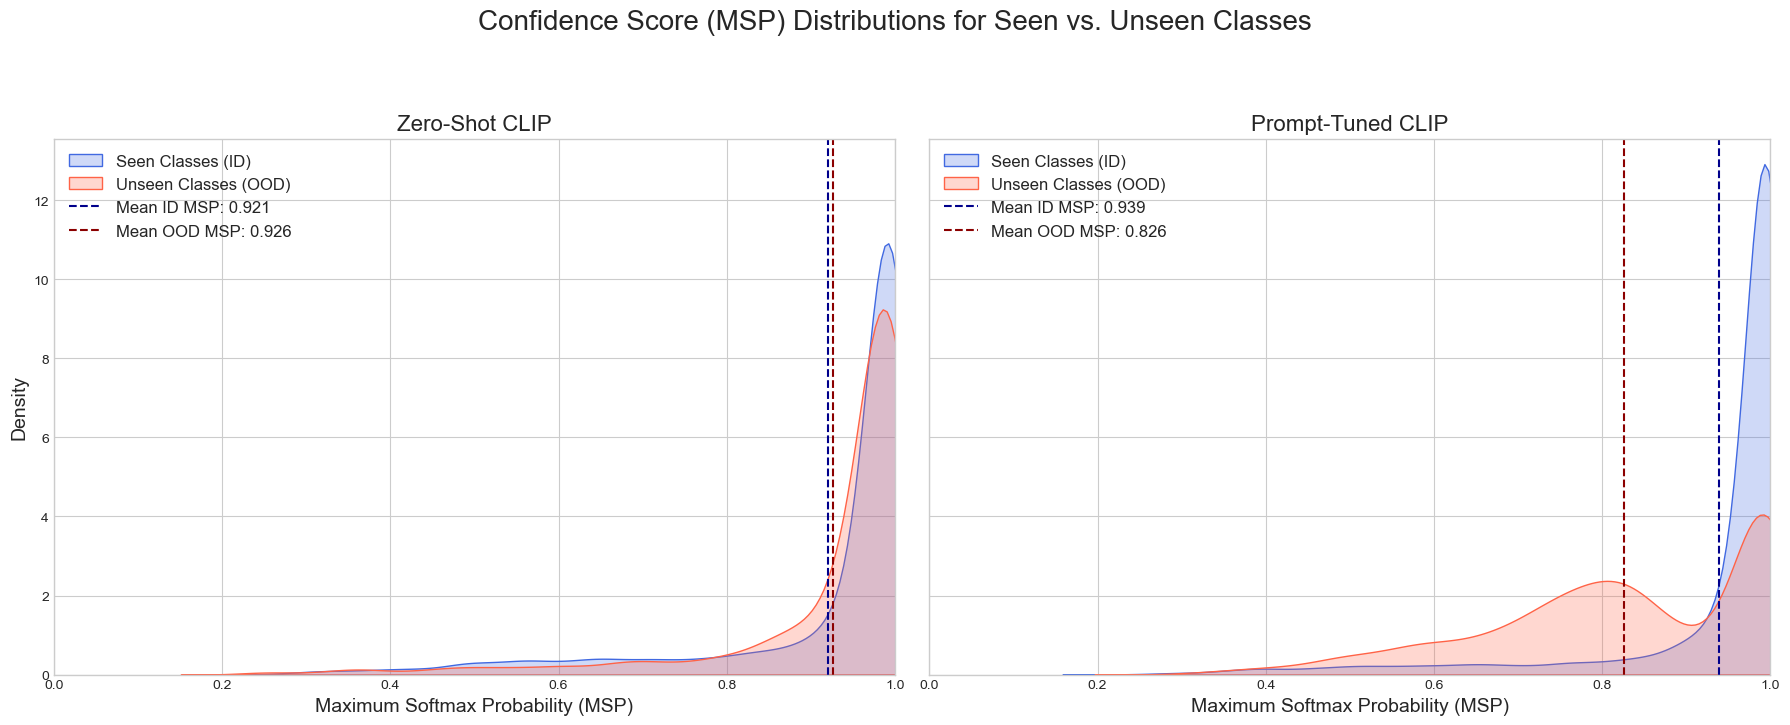

Generating Plot 2: Performance Metrics Bar Chart...


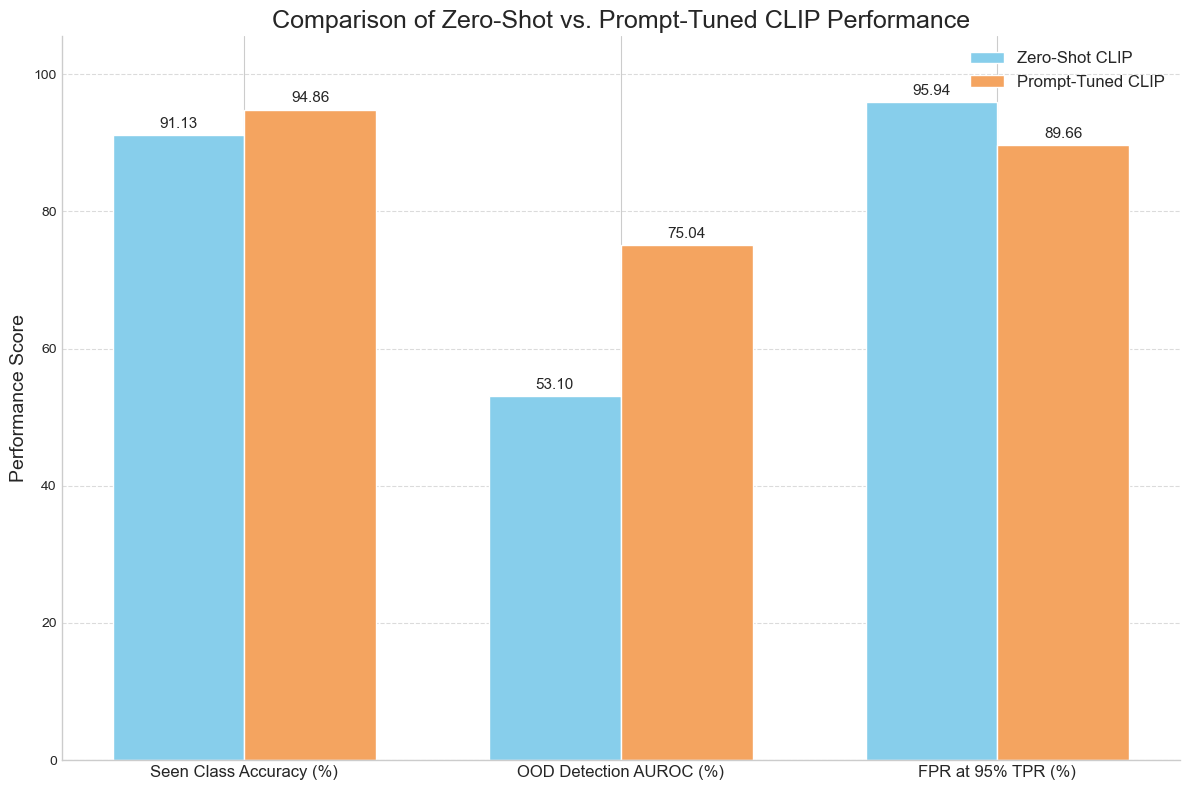

Generating Plot 3 (Corrected): Prompt Embedding Similarity Heatmap...


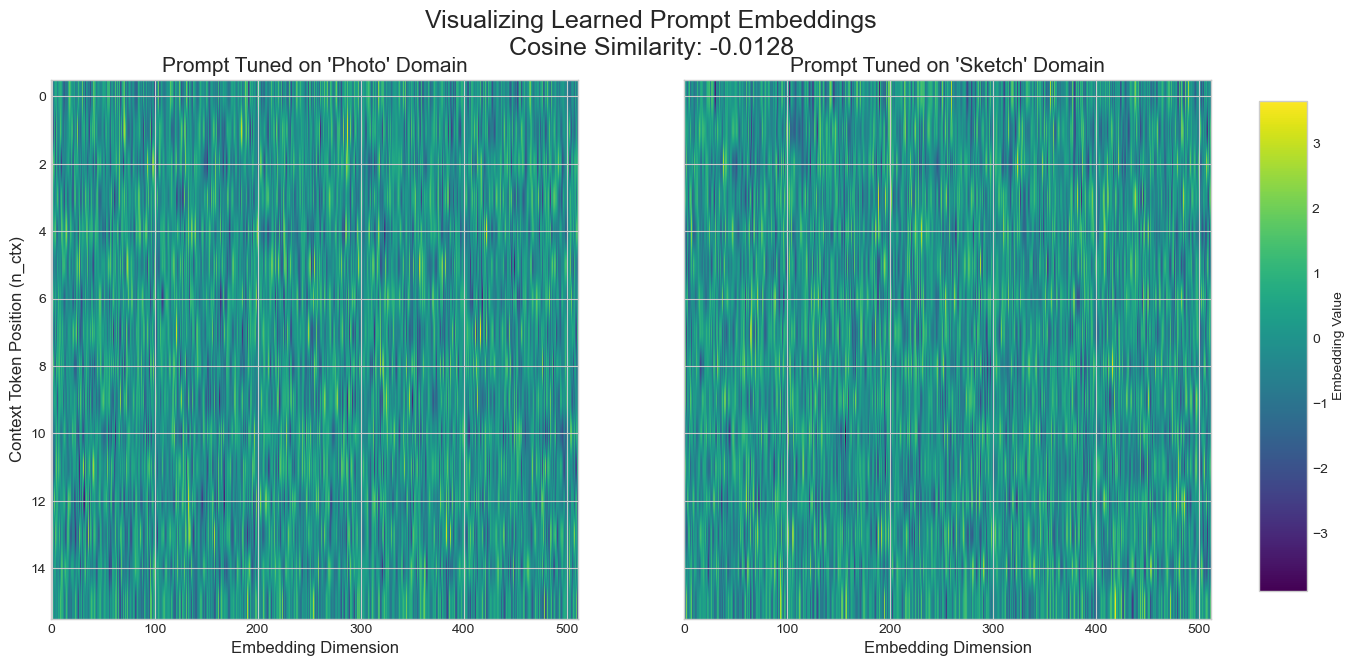

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm


print("\n" + "="*50 + "\nGENERATING VISUALIZATIONS\n" + "="*50)



def evaluate_open_set_with_scores(model, seen_loader, unseen_loader, text_features):
 
    model.eval()
    id_msp, correct, total = [], 0, 0
    with torch.no_grad():
        for images, _, global_targets in tqdm(seen_loader, desc="Gathering Seen (ID) Scores"):
            images = images.to(DEVICE)
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            logits = (100.0 * image_features @ text_features.T)
            probs = logits.softmax(dim=-1)
            msp, preds = torch.max(probs, dim=1)

            id_msp.extend(msp.cpu().numpy())
            total += global_targets.size(0)
            correct += (preds.cpu() == global_targets).sum().item()

    ood_msp = []
    with torch.no_grad():
        for images, _, _ in tqdm(unseen_loader, desc="Gathering Unseen (OOD) Scores"):
            images = images.to(DEVICE)
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            logits = (100.0 * image_features @ text_features.T)
            probs = logits.softmax(dim=-1)
            msp, _ = torch.max(probs, dim=1)
            ood_msp.extend(msp.cpu().numpy())

    return id_msp, ood_msp


zero_shot_id_scores, zero_shot_ood_scores = evaluate_open_set_with_scores(
    clip_model, seen_test_loader, unseen_test_loader, zero_shot_text_features
)


tuned_id_scores, tuned_ood_scores = evaluate_open_set_with_scores(
    clip_model, seen_test_loader, unseen_test_loader, tuned_text_features
)



print("\nGenerating Plot 1: Confidence Score Distributions...")
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharex=True, sharey=True)
fig.suptitle('Confidence Score (MSP) Distributions for Seen vs. Unseen Classes', fontsize=20, y=1.03)

sns.kdeplot(data=zero_shot_id_scores, ax=axes[0], label='Seen Classes (ID)', fill=True, color='royalblue', warn_singular=False)
sns.kdeplot(data=zero_shot_ood_scores, ax=axes[0], label='Unseen Classes (OOD)', fill=True, color='tomato', warn_singular=False)
axes[0].set_title('Zero-Shot CLIP', fontsize=16)
axes[0].set_xlabel('Maximum Softmax Probability (MSP)', fontsize=14)
axes[0].set_ylabel('Density', fontsize=14)
axes[0].axvline(np.mean(zero_shot_id_scores), color='darkblue', linestyle='--', label=f"Mean ID MSP: {np.mean(zero_shot_id_scores):.3f}")
axes[0].axvline(np.mean(zero_shot_ood_scores), color='darkred', linestyle='--', label=f"Mean OOD MSP: {np.mean(zero_shot_ood_scores):.3f}")
axes[0].legend(fontsize=12)
axes[0].set_xlim(0, 1)

# Plot for Prompt-Tuned CLIP
sns.kdeplot(data=tuned_id_scores, ax=axes[1], label='Seen Classes (ID)', fill=True, color='royalblue', warn_singular=False)
sns.kdeplot(data=tuned_ood_scores, ax=axes[1], label='Unseen Classes (OOD)', fill=True, color='tomato', warn_singular=False)
axes[1].set_title('Prompt-Tuned CLIP', fontsize=16)
axes[1].set_xlabel('Maximum Softmax Probability (MSP)', fontsize=14)
axes[1].axvline(np.mean(tuned_id_scores), color='darkblue', linestyle='--', label=f"Mean ID MSP: {np.mean(tuned_id_scores):.3f}")
axes[1].axvline(np.mean(tuned_ood_scores), color='darkred', linestyle='--', label=f"Mean OOD MSP: {np.mean(tuned_ood_scores):.3f}")
axes[1].legend(fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


print("Generating Plot 2: Performance Metrics Bar Chart...")
labels = ['Seen Class Accuracy (%)', 'OOD Detection AUROC (%)', 'FPR at 95% TPR (%)']
zero_shot_values = [
    zero_shot_metrics['id_accuracy'],
    zero_shot_metrics['auroc'],
    zero_shot_metrics['fpr_at_95_tpr']
]
tuned_values = [
    tuned_metrics['id_accuracy'],
    tuned_metrics['auroc'],
    tuned_metrics['fpr_at_95_tpr']
]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, zero_shot_values, width, label='Zero-Shot CLIP', color='skyblue')
rects2 = ax.bar(x + width/2, tuned_values, width, label='Prompt-Tuned CLIP', color='sandybrown')

ax.set_ylabel('Performance Score', fontsize=14)
ax.set_title('Comparison of Zero-Shot vs. Prompt-Tuned CLIP Performance', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.bar_label(rects1, padding=3, fmt='%.2f', fontsize=11)
ax.bar_label(rects2, padding=3, fmt='%.2f', fontsize=11)
ax.set_ylim(0, max(max(zero_shot_values), max(tuned_values)) * 1.1)

fig.tight_layout()
plt.show()


if 'source_prompt' in locals() and 'target_prompt' in locals() and source_prompt is not None and target_prompt is not None:
    print("Generating Plot 3 (Corrected): Prompt Embedding Similarity Heatmap...")

    similarity = F.cosine_similarity(source_prompt.flatten().unsqueeze(0), target_prompt.flatten().unsqueeze(0))

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle(f'Visualizing Learned Prompt Embeddings\nCosine Similarity: {similarity.item():.4f}', fontsize=18)

    vmin = min(source_prompt.min(), target_prompt.min()).item()
    vmax = max(source_prompt.max(), target_prompt.max()).item()

    axes[0].imshow(source_prompt.cpu().numpy(), cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
    axes[0].set_title("Prompt Tuned on 'Photo' Domain", fontsize=15)
    axes[0].set_xlabel("Embedding Dimension", fontsize=12)
    axes[0].set_ylabel("Context Token Position (n_ctx)", fontsize=12)


    im = axes[1].imshow(target_prompt.cpu().numpy(), cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
    axes[1].set_title("Prompt Tuned on 'Sketch' Domain", fontsize=15)
    axes[1].set_xlabel("Embedding Dimension", fontsize=12)
    axes[1].set_yticklabels([])

    fig.subplots_adjust(right=0.85) 
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7]) 
    fig.colorbar(im, cax=cbar_ax, label='Embedding Value')

    plt.show()
else:
    print("\nSkipping Plot 3: Could not generate prompt similarity heatmap because source or target prompts were not trained.")

PART 2


In [3]:
import os
import clip
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
torch.cuda.empty_cache()

DATASET_PATH = "../task1/pacs_data/pacs_data/"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLIP_MODEL_NAME = "ViT-B/32"
MODEL_SAVE_PATH = "./saved_models/" 
torch.manual_seed(42)


SOURCE_DOMAIN = 'photo'
TARGET_DOMAIN = 'sketch'


LEARNING_RATE = 0.002
NUM_EPOCHS = 5
BATCH_SIZE = 32
PSEUDO_LABEL_THRESHOLD = 0.9 
LAMBDA_U = 1.0                


os.makedirs(MODEL_SAVE_PATH, exist_ok=True)


if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset directory not found at {DATASET_PATH}. Please check the path.")


clip_model, preprocess = clip.load(CLIP_MODEL_NAME, device=DEVICE)
for param in clip_model.parameters():
    param.requires_grad = False  
print(f"CLIP model '{CLIP_MODEL_NAME}' loaded to {DEVICE}.")
print(f"Source Domain: '{SOURCE_DOMAIN}', Target Domain: '{TARGET_DOMAIN}'")
print(f"Models will be saved to/loaded from: '{MODEL_SAVE_PATH}'\n")


class PACSDomainDataset(ImageFolder):

    def __init__(self, domain_path, transform=None):
        if not os.path.isdir(domain_path):
            raise FileNotFoundError(f"Domain path does not exist: {domain_path}")
        super().__init__(root=domain_path, transform=transform)

source_path = os.path.join(DATASET_PATH, SOURCE_DOMAIN)
CLASS_NAMES = sorted([d for d in os.listdir(source_path) if os.path.isdir(os.path.join(source_path, d))])
print(f"Classes being used: {CLASS_NAMES}\n")

source_train_dataset = PACSDomainDataset(os.path.join(DATASET_PATH, SOURCE_DOMAIN), transform=preprocess)
target_train_dataset = PACSDomainDataset(os.path.join(DATASET_PATH, TARGET_DOMAIN), transform=preprocess)
target_test_dataset = PACSDomainDataset(os.path.join(DATASET_PATH, TARGET_DOMAIN), transform=preprocess)

source_train_loader = DataLoader(source_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
target_train_loader = DataLoader(target_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
target_test_loader = DataLoader(target_test_dataset, batch_size=BATCH_SIZE, shuffle=False)



def _get_text_features_from_embeddings(model, tokenized_prompts, prompt_embeddings):
    x = prompt_embeddings + model.positional_embedding.type(model.dtype)
    x = x.permute(1, 0, 2)
    x = model.transformer(x)
    x = x.permute(1, 0, 2)
    x = model.ln_final(x).type(model.dtype)
    x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ model.text_projection
    return x

class PromptTunedCLIP(nn.Module):
    def __init__(self, clip_model, class_names, n_ctx=16):
        super().__init__()
        self.clip_model = clip_model
        ctx_dim = clip_model.ln_final.weight.shape[0]
        self.ctx = nn.Parameter(torch.randn(n_ctx, ctx_dim))
        prompts = [f"X " * n_ctx + name.replace("_", " ") for name in class_names]
        self.tokenized_prompts = clip.tokenize(prompts).to(DEVICE)
        with torch.no_grad():
            embedding = clip_model.token_embedding(self.tokenized_prompts).type(clip_model.dtype)
        self.register_buffer("token_prefix", embedding[:, :1, :])
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])

    def get_text_features(self):
        ctx = self.ctx.type(self.clip_model.dtype).unsqueeze(0).expand(len(self.tokenized_prompts), -1, -1)
        prompt_embeddings = torch.cat([self.token_prefix, ctx, self.token_suffix], dim=1)
        text_features = _get_text_features_from_embeddings(self.clip_model, self.tokenized_prompts, prompt_embeddings)
        return text_features / text_features.norm(dim=-1, keepdim=True)
        
    def forward(self, image_features):
        text_features = self.get_text_features()
        return 100.0 * image_features @ text_features.T

def evaluate(model, dataloader, is_zero_shot=False):
    model.eval()
    correct, total = 0, 0
    if is_zero_shot:
        with torch.no_grad():
            texts = [f"a photo of a {c.replace('_', ' ')}" for c in CLASS_NAMES]
            text_tokens = clip.tokenize(texts).to(DEVICE)
            text_features = clip_model.encode_text(text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)
    else:
        text_features = model.get_text_features()

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = 100.0 * image_features @ text_features.T
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return (correct / total) * 100 if total > 0 else 0



results = {}


print("\n--- Running Baseline 1: Zero-Shot CLIP ---")
zero_shot_accuracy = evaluate(clip_model, target_test_loader, is_zero_shot=True)
results['Zero-Shot'] = zero_shot_accuracy
print(f"\nZero-Shot Accuracy on Target Domain ('{TARGET_DOMAIN}'): {zero_shot_accuracy:.2f}%\n")



source_only_model = PromptTunedCLIP(clip_model, CLASS_NAMES).to(DEVICE)
source_only_model_path = os.path.join(MODEL_SAVE_PATH, "source_only_prompt_model.pth")

if os.path.exists(source_only_model_path):
    print(f"--- Loading pre-trained Source-Only model from {source_only_model_path} ---")
    source_only_model.load_state_dict(torch.load(source_only_model_path, map_location=DEVICE))
else:
    print("\n--- Running Baseline 2: Source-Only Prompt Tuning (CoOp) ---")
    optimizer = torch.optim.AdamW(source_only_model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(NUM_EPOCHS):
        source_only_model.train()
        total_loss = 0
        for images, labels in tqdm(source_train_loader, desc=f"Source-Only Epoch {epoch+1}/{NUM_EPOCHS}"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            with torch.no_grad():
                image_features = clip_model.encode_image(images)
                image_features /= image_features.norm(dim=-1, keepdim=True)
            optimizer.zero_grad()
            logits = source_only_model(image_features)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} Average Loss: {total_loss / len(source_train_loader):.4f}")
    
    print(f"\nSaving trained Source-Only model to {source_only_model_path}")
    torch.save(source_only_model.state_dict(), source_only_model_path)

source_only_accuracy = evaluate(source_only_model, target_test_loader)
results['Source-Only (CoOp)'] = source_only_accuracy
print(f"\nSource-Only Model Accuracy on Target Domain ('{TARGET_DOMAIN}'): {source_only_accuracy:.2f}%\n")



uda_model = PromptTunedCLIP(clip_model, CLASS_NAMES).to(DEVICE)
uda_model_path = os.path.join(MODEL_SAVE_PATH, "uda_prompt_model.pth")

if os.path.exists(uda_model_path):
    print(f"--- Loading pre-trained UDA model from {uda_model_path} ---")
    uda_model.load_state_dict(torch.load(uda_model_path, map_location=DEVICE))
else:
    print("\n--- Running Experiment 3: UDA with Pseudo-Labeling ---")
    optimizer = torch.optim.AdamW(uda_model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(NUM_EPOCHS):
        uda_model.train()
        total_s_loss, total_u_loss, u_samples = 0, 0, 0
        target_iter = iter(target_train_loader)
        for source_images, source_labels in tqdm(source_train_loader, desc=f"UDA Epoch {epoch+1}/{NUM_EPOCHS}"):
            try:
                target_images, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_train_loader)
                target_images, _ = next(target_iter)
            
            source_images, source_labels = source_images.to(DEVICE), source_labels.to(DEVICE)
            target_images = target_images.to(DEVICE)
            s_batch_size = source_images.shape[0]

            all_images = torch.cat([source_images, target_images])
            with torch.no_grad():
                all_features = clip_model.encode_image(all_images)
                all_features /= all_features.norm(dim=-1, keepdim=True)
            
            source_features, target_features = all_features[:s_batch_size], all_features[s_batch_size:]
            
            logits_s = uda_model(source_features)
            loss_s = criterion(logits_s, source_labels)

            with torch.no_grad():
                logits_u = uda_model(target_features)
                probs_u = logits_u.softmax(dim=-1)
                max_probs, pseudo_labels = torch.max(probs_u, dim=-1)
                mask = max_probs > PSEUDO_LABEL_THRESHOLD
            
            loss_u = torch.tensor(0.0).to(DEVICE)
            if mask.sum() > 0:
                logits_u_masked = uda_model(target_features[mask])
                loss_u = criterion(logits_u_masked, pseudo_labels[mask])
                u_samples += mask.sum().item()

            total_loss = loss_s + LAMBDA_U * loss_u
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            total_s_loss += loss_s.item()
            if isinstance(loss_u, torch.Tensor):
                total_u_loss += loss_u.item()
        
        print(f"Epoch {epoch+1} Avg Loss -> Source: {total_s_loss/len(source_train_loader):.4f}, Target (UDA): {total_u_loss/len(source_train_loader):.4f} ({u_samples} samples used)")
    
    print(f"\nSaving trained UDA model to {uda_model_path}")
    torch.save(uda_model.state_dict(), uda_model_path)

uda_accuracy = evaluate(uda_model, target_test_loader)
results['UDA w/ Pseudo-Labels'] = uda_accuracy
print(f"\nUDA Model Accuracy on Target Domain ('{TARGET_DOMAIN}'): {uda_accuracy:.2f}%\n")



print("\n" + "="*70)
print("                       DOMAIN ADAPTATION RESULTS")
print("="*70)
print(f"Source Domain: '{SOURCE_DOMAIN}' -> Target Domain: '{TARGET_DOMAIN}'\n")
print(f"{'Method':<25} | {'Target Accuracy':<20}")
print("-"*50)
for method, acc in results.items():
    print(f"{method:<25} | {acc:.2f}%")
print("="*70)

# print("\n### Analysis and Discussion\n")
# print("1. **Target Performance Comparison:**")
# if results['UDA w/ Pseudo-Labels'] > results['Source-Only (CoOp)']:
#     improvement = results['UDA w/ Pseudo-Labels'] - results['Source-Only (CoOp)']
#     print(f"The UDA approach with pseudo-labeling successfully improved performance on the target domain, outperforming the Source-Only baseline by {improvement:.2f}%. This demonstrates that incorporating unlabeled target data, even with a simple unsupervised loss, is effective for adaptation.")
# else:
#     print("The UDA approach did not outperform the Source-Only baseline. This could be due to noisy pseudo-labels, suboptimal hyperparameters (like the confidence threshold), or the domain gap being too large for this method to bridge effectively.")
# if results['Source-Only (CoOp)'] > results['Zero-Shot']:
#      print("Furthermore, even simple prompt tuning on the source domain (Source-Only) provided a significant boost over the generic Zero-Shot CLIP, showing the value of creating specialized textual contexts.")
# else:
#      print("Interestingly, simple prompt tuning on the source domain (Source-Only) did not outperform the generic Zero-Shot CLIP. This suggests the learned prompt overfit heavily to the source domain's visual style and failed to generalize.")



CLIP model 'ViT-B/32' loaded to cuda.
Source Domain: 'photo', Target Domain: 'sketch'
Models will be saved to/loaded from: './saved_models/'

Classes being used: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']


--- Running Baseline 1: Zero-Shot CLIP ---


Evaluating: 100%|██████████| 123/123 [00:11<00:00, 10.85it/s]
C:\Users\xylic\AppData\Local\Temp\ipykernel_25256\3029818897.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature


Zero-Shot Accuracy on Target Domain ('sketch'): 84.86%

--- Loading pre-trained Source-Only model from ./saved_models/source_only_prompt_model.pth ---


Evaluating: 100%|██████████| 123/123 [00:10<00:00, 11.52it/s]
C:\Users\xylic\AppData\Local\Temp\ipykernel_25256\3029818897.py:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature


Source-Only Model Accuracy on Target Domain ('sketch'): 86.61%

--- Loading pre-trained UDA model from ./saved_models/uda_prompt_model.pth ---


Evaluating: 100%|██████████| 123/123 [00:11<00:00, 11.00it/s]


UDA Model Accuracy on Target Domain ('sketch'): 89.77%


                       DOMAIN ADAPTATION RESULTS
Source Domain: 'photo' -> Target Domain: 'sketch'

Method                    | Target Accuracy     
--------------------------------------------------
Zero-Shot                 | 84.86%
Source-Only (CoOp)        | 86.61%
UDA w/ Pseudo-Labels      | 89.77%


Visualization for Part 2:

C:\Users\xylic\AppData\Local\Temp\ipykernel_25256\1202163367.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  uda_model.load_state_dict(torch.load(uda_model_path, map_lo

Successfully loaded UDA model for visualizations.

Generating Visualization 1: Bar Chart of Final Accuracies...


C:\Users\xylic\AppData\Local\Temp\ipykernel_25256\1202163367.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods, rotation=0, ha='center', fontsize=11)


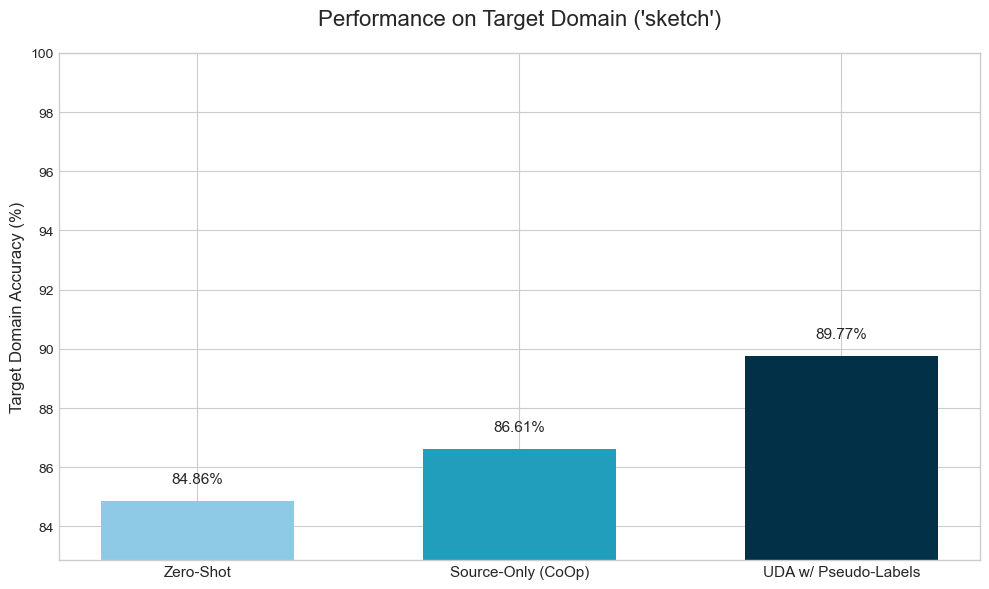


Generating Visualization 2: t-SNE plot (this might take a minute)...


Extracting features for t-SNE: 100%|██████████| 16/16 [00:02<00:00,  5.53it/s]
d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.900277
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.101475
[t-SNE] KL divergence after 300 iterations: 1.205442
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.900277


d:\anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.101475
[t-SNE] KL divergence after 300 iterations: 1.205442


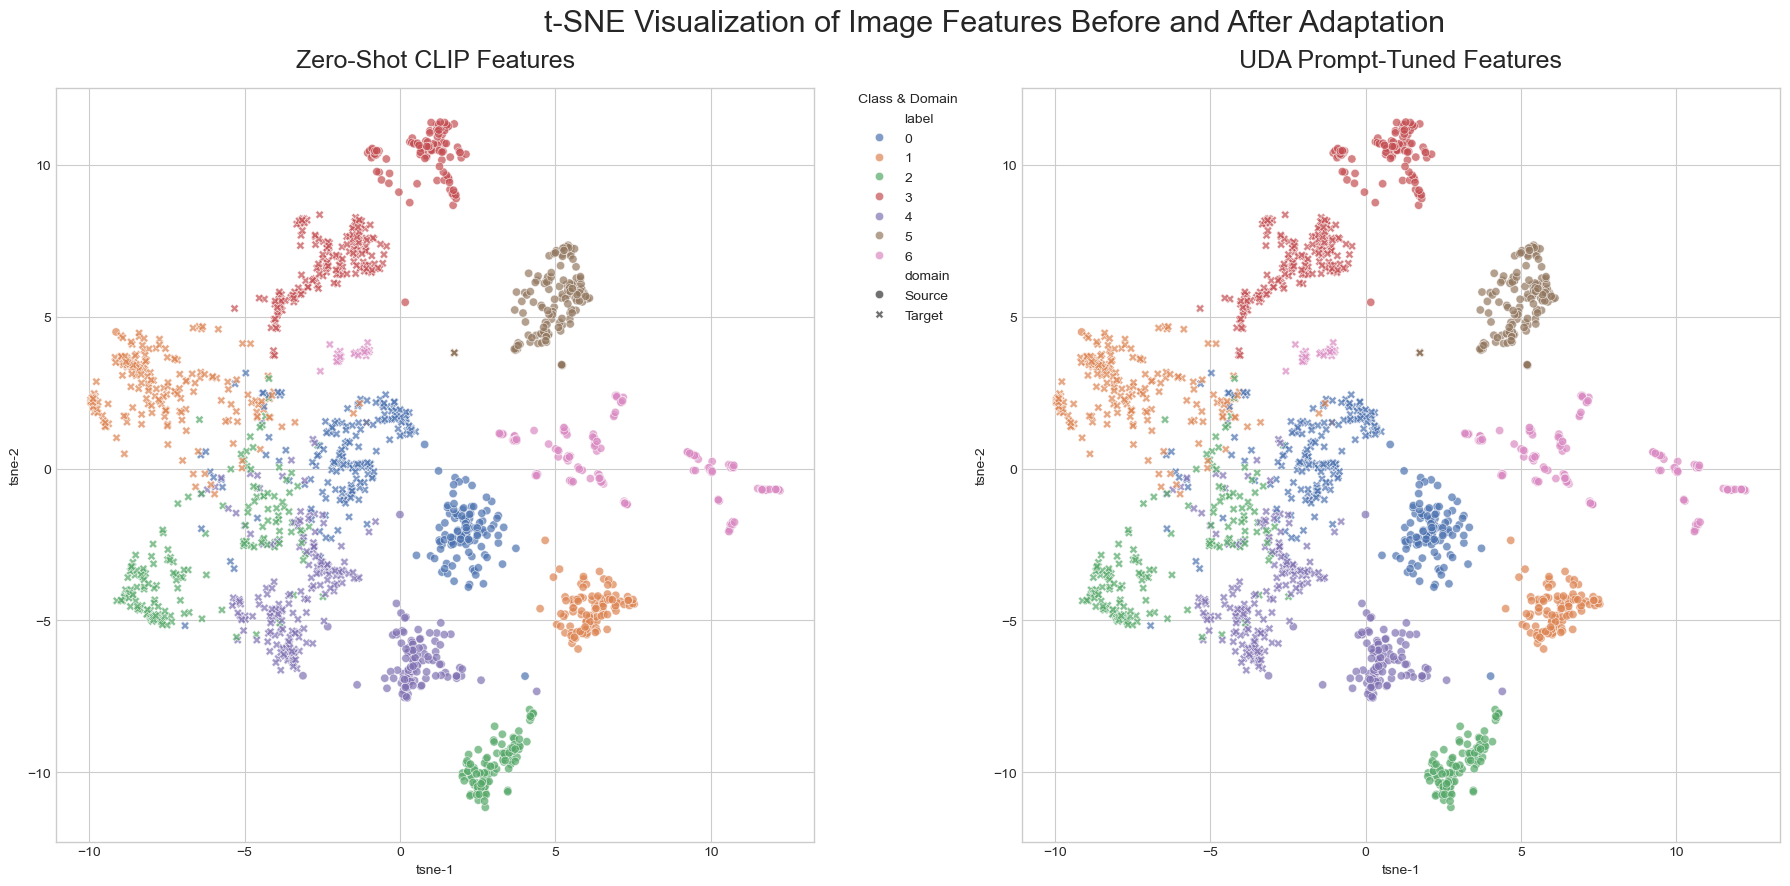


Generating Visualization 3: Confusion Matrix for UDA Model...


Getting predictions: 100%|██████████| 62/62 [00:34<00:00,  1.80it/s]


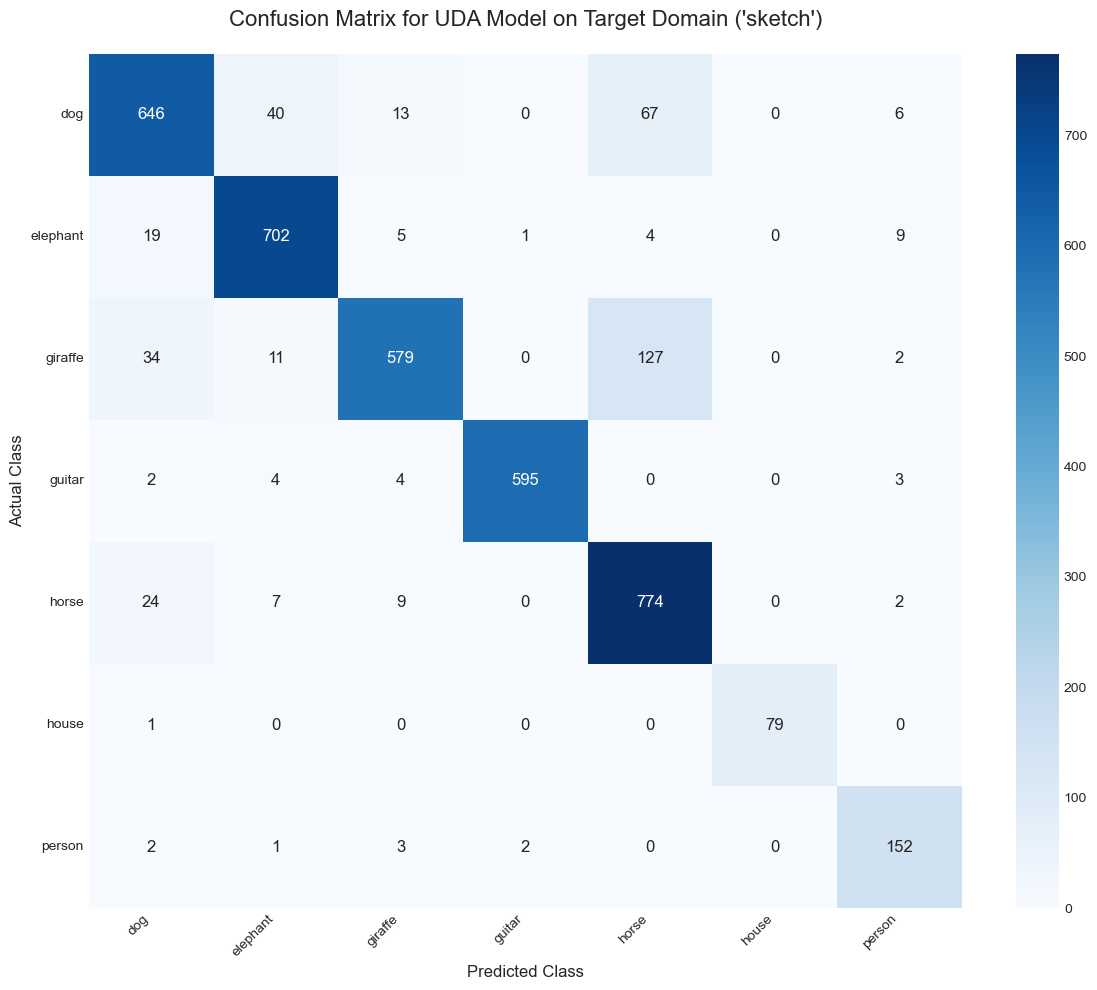

In [ ]:
import os
import clip
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import pandas as pd


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CLIP_MODEL_NAME = "ViT-B/32"
MODEL_SAVE_PATH = "./saved_models/"
DATASET_PATH = "../task1/pacs_data/pacs_data/"
SOURCE_DOMAIN = 'photo'
TARGET_DOMAIN = 'sketch'


clip_model, preprocess = clip.load(CLIP_MODEL_NAME, device=DEVICE)

def _get_text_features_from_embeddings(model, tokenized_prompts, prompt_embeddings):
    x = prompt_embeddings + model.positional_embedding.type(model.dtype)
    x = x.permute(1, 0, 2)
    x = model.transformer(x)
    x = x.permute(1, 0, 2)
    x = model.ln_final(x).type(model.dtype)
    x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ model.text_projection
    return x

class PromptTunedCLIP(nn.Module):
    def __init__(self, clip_model, class_names, n_ctx=16):
        super().__init__()
        self.clip_model = clip_model
        ctx_dim = clip_model.ln_final.weight.shape[0]
        self.ctx = nn.Parameter(torch.randn(n_ctx, ctx_dim))
        prompts = [f"X " * n_ctx + name.replace("_", " ") for name in class_names]
        self.tokenized_prompts = clip.tokenize(prompts).to(DEVICE)
        with torch.no_grad():
            embedding = clip_model.token_embedding(self.tokenized_prompts).type(clip_model.dtype)
        self.register_buffer("token_prefix", embedding[:, :1, :])
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])

    def get_text_features(self):
        ctx = self.ctx.type(self.clip_model.dtype).unsqueeze(0).expand(len(self.tokenized_prompts), -1, -1)
        prompt_embeddings = torch.cat([self.token_prefix, ctx, self.token_suffix], dim=1)
        text_features = _get_text_features_from_embeddings(self.clip_model, self.tokenized_prompts, prompt_embeddings)
        return text_features / text_features.norm(dim=-1, keepdim=True)


source_path = os.path.join(DATASET_PATH, SOURCE_DOMAIN)
CLASS_NAMES = sorted([d for d in os.listdir(source_path) if os.path.isdir(os.path.join(source_path, d))])

source_dataset = ImageFolder(os.path.join(DATASET_PATH, SOURCE_DOMAIN), transform=preprocess)
target_dataset = ImageFolder(os.path.join(DATASET_PATH, TARGET_DOMAIN), transform=preprocess)

source_loader = DataLoader(source_dataset, batch_size=64, shuffle=False)
target_loader = DataLoader(target_dataset, batch_size=64, shuffle=False)


uda_model = PromptTunedCLIP(clip_model, CLASS_NAMES).to(DEVICE)
uda_model_path = os.path.join(MODEL_SAVE_PATH, "uda_prompt_model.pth")
if os.path.exists(uda_model_path):
    uda_model.load_state_dict(torch.load(uda_model_path, map_location=DEVICE))
    print("Successfully loaded UDA model for visualizations.")
else:
    print("Could not find saved UDA model. Please run the training script first.")
    exit()


results = {
    'Zero-Shot': 84.86,
    'Source-Only (CoOp)': 86.61,
    'UDA w/ Pseudo-Labels': 89.77
}


print("\nGenerating Visualization 1: Bar Chart of Final Accuracies...")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

methods = list(results.keys())
accuracies = list(results.values())
colors = ['#8ecae6', '#219ebc', '#023047']

bars = ax.bar(methods, accuracies, color=colors, width=0.6)

ax.set_ylim(min(accuracies) - 2, 100)
ax.set_ylabel('Target Domain Accuracy (%)', fontsize=12)
ax.set_title(f"Performance on Target Domain ('{TARGET_DOMAIN}')", fontsize=16, pad=20)
ax.set_xticklabels(methods, rotation=0, ha='center', fontsize=11)


for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig("accuracy_comparison_barchart.png", dpi=300)
plt.show()


def get_features_for_tsne(model, dataloader, model_type='prompted'):
    features_list = []
    labels_list = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Extracting features for t-SNE"):
            images = images.to(DEVICE)
            if model_type == 'zero-shot':
                 image_features = model.encode_image(images)
            else: 
                 image_features = model.clip_model.encode_image(images)
            
            features_list.append(image_features.cpu())
            labels_list.append(labels.cpu())
    return torch.cat(features_list).numpy(), torch.cat(labels_list).numpy()


num_samples_tsne = 1000
source_subset_indices = np.random.choice(len(source_dataset), num_samples_tsne, replace=False)
target_subset_indices = np.random.choice(len(target_dataset), num_samples_tsne, replace=False)

source_subset = torch.utils.data.Subset(source_dataset, source_subset_indices)
target_subset = torch.utils.data.Subset(target_dataset, target_subset_indices)

source_tsne_loader = DataLoader(source_subset, batch_size=64, shuffle=False)
target_tsne_loader = DataLoader(target_subset, batch_size=64, shuffle=False)


source_feats_zs, source_labels_zs = get_features_for_tsne(clip_model, source_tsne_loader, 'zero-shot')
target_feats_zs, target_labels_zs = get_features_for_tsne(clip_model, target_tsne_loader, 'zero-shot')


source_feats_uda, source_labels_uda = get_features_for_tsne(uda_model, source_tsne_loader, 'prompted')
target_feats_uda, target_labels_uda = get_features_for_tsne(uda_model, target_tsne_loader, 'prompted')


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)

all_feats_zs = np.concatenate((source_feats_zs, target_feats_zs))
tsne_results_zs = tsne.fit_transform(all_feats_zs)

all_feats_uda = np.concatenate((source_feats_uda, target_feats_uda))
tsne_results_uda = tsne.fit_transform(all_feats_uda)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
palette = sns.color_palette("deep", len(CLASS_NAMES))


df_zs = pd.DataFrame({
    'tsne-1': tsne_results_zs[:,0], 'tsne-2': tsne_results_zs[:,1],
    'label': np.concatenate((source_labels_zs, target_labels_zs)),
    'domain': ['Source'] * len(source_feats_zs) + ['Target'] * len(target_feats_zs)
})

sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="label", style="domain",
    palette=palette,
    data=df_zs,
    legend="full",
    alpha=0.7,
    ax=ax1
)
ax1.set_title('Zero-Shot CLIP Features', fontsize=18, pad=15)
ax1.legend(title='Class & Domain', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


df_uda = pd.DataFrame({
    'tsne-1': tsne_results_uda[:,0], 'tsne-2': tsne_results_uda[:,1],
    'label': np.concatenate((source_labels_uda, target_labels_uda)),
    'domain': ['Source'] * len(source_feats_uda) + ['Target'] * len(target_feats_uda)
})

sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="label", style="domain",
    palette=palette,
    data=df_uda,
    legend="full",
    alpha=0.7,
    ax=ax2
)
ax2.set_title('UDA Prompt-Tuned Features', fontsize=18, pad=15)
ax2.get_legend().remove() 

fig.suptitle('t-SNE Visualization of Image Features Before and After Adaptation', fontsize=22)
plt.tight_layout(rect=[0, 0, 0.9, 1]) 
plt.savefig("feature_space_tsne.png", dpi=300)
plt.show()


print("\nGenerating Visualization 3: Confusion Matrix for UDA Model...")

def get_predictions(model, dataloader):
    preds_list = []
    labels_list = []
    text_features = model.get_text_features()
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Getting predictions"):
            images = images.to(DEVICE)
            image_features = model.clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = 100.0 * image_features @ text_features.T
            preds = torch.argmax(logits, dim=1)
            preds_list.append(preds.cpu())
            labels_list.append(labels.cpu())
    return torch.cat(preds_list).numpy(), torch.cat(labels_list).numpy()


y_pred, y_true = get_predictions(uda_model, target_loader)


cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 12})
plt.title(f"Confusion Matrix for UDA Model on Target Domain ('{TARGET_DOMAIN}')", fontsize=16, pad=20)
plt.ylabel('Actual Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("confusion_matrix_uda.png", dpi=300)
plt.show()